In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import os
from os.path import join
import pandas as pd
import fiona
from cartopy import crs as ccrs
# from urllib.request import urlopen
# from zipfile import ZipFile
# from io import BytesIO
# from pathlib import Path

sns.set(style='white')
cwd = os.getcwd()
data_path = join(cwd, '..', '..', 'Data storage')
figure_path = join(cwd, '..', '..', 'Figures')
file_date = '2018-03-06'

In [2]:
%load_ext watermark
%watermark -v -p pandas,geopandas,shapely

CPython 3.6.3
IPython 6.2.1

pandas 0.22.0
geopandas 0.3.0
shapely 1.6.4.post1


## Read NERC regions shapefile
[Link to the shapefile](https://github.com/gschivley/Index-variability/raw/master/Data%20storage/NERC_Regions_EIA) for local download

In [3]:
# EIA NERC region shapefile, which has an "Indeterminate" region

# path = os.path.join(data_path, 'NERC_Regions_EIA', 'NercRegions_201610.shp')
# regions = gpd.read_file(path)
# regions.crs

{'init': 'epsg:4326'}

Now using NERC region shapefiles [created by DHS](https://hifld-dhs-gii.opendata.arcgis.com/datasets/12582592aeb842f5a7aab556a57a10d1_0)

In [5]:
path = os.path.join(data_path, 'NERC_Regions', 'NERC_Regions.shp')
regions = gpd.read_file(path)
regions.columns = regions.columns.str.lower()
regions['nerc'] = regions['name'].str.split().str[-1].str.strip('()')
regions = regions.loc[:, ['nerc', 'geometry']]
regions.head()

,nerc,geometry
0,WECC,"(POLYGON ((-106.940414613533 38.5297752935145,..."
1,WECC,"(POLYGON ((-124.166090785201 41.0947342364264,..."
2,TRE,"(POLYGON ((-123.715621602827 44.0113707388719,..."
3,FRCC,"(POLYGON ((-85.7661778899989 30.3156300105005,..."
4,NPCC,"(POLYGON ((-67.1335131587897 45.1268843657456,..."


In [6]:
# This is slow! 

regions_nerc = regions.dissolve(by='nerc', as_index=False)

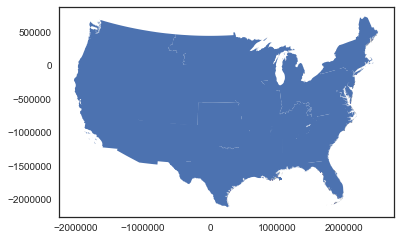

In [8]:
regions_nerc.to_crs(epsg=2163).plot()

In [ ]:
path = join(data_path, 'NERC Regions', 'Aggregated NERC Regions')
regions_nerc.to_file('NERC_regions')

In [22]:
path = os.path.join(data_path, 'cb_2016_us_state_20m', 'cb_2016_us_state_20m.shp')
states = gpd.read_file(path)
states.crs

{'init': 'epsg:4269'}

In [23]:
drop_states = ['Alaska', 'Hawaii', 'Puerto Rico']
states = states.loc[~states['NAME'].isin(drop_states)]

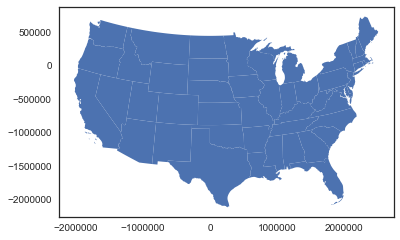

In [24]:
states.to_crs(epsg=2163).plot()

In [16]:
path = join(data_path, 'final NERC data',
            'Summary table {}.csv'.format(file_date))
index = pd.read_csv(path)
index

,nerc,2001,2017,Reduction,Percent Reduction,Annual Reduction
0,TRE,609.480997,445.396025,164.084972,0.269221,10.255311
1,WECC,520.628493,346.627554,174.000939,0.334213,10.875059
2,USA,629.016312,438.047363,190.968949,0.303599,11.935559
3,SERC,633.368212,426.814179,206.554033,0.326120,12.909627
4,RFC,676.181487,461.065520,215.115966,0.318133,13.444748
5,FRCC,648.223415,410.133060,238.090355,0.367297,14.880647
6,NPCC,414.395302,172.744904,241.650399,0.583140,15.103150
7,MRO,855.109267,541.516736,313.592531,0.366728,19.599533
8,SPP,853.801162,494.664676,359.136486,0.420632,22.446030


In [367]:
for nerc in regions['NERC'].unique():
    try:
        val_2017 = index.loc[index['nerc']==nerc, '2017'].values[0]
        val_2001 = index.loc[index['nerc']==nerc, '2001'].values[0]
        reduce = index.loc[index['nerc']==nerc, 'Percent Reduction'].values[0]
#         print(val)
        regions.loc[regions['NERC']==nerc, 2017] = val_2017
        regions.loc[regions['NERC']==nerc, 2001] = val_2001
        
        regions.loc[regions['NERC']==nerc, 'reduction'] = '{:.0%}'.format(reduce)
        regions.loc[regions['NERC']==nerc, 'reduction value'] = reduce
    except:
        pass

In [17]:
for nerc in regions_nerc['nerc'].unique():
    try:
        val_2017 = index.loc[index['nerc']==nerc, '2017'].values[0]
        val_2001 = index.loc[index['nerc']==nerc, '2001'].values[0]
        reduce = index.loc[index['nerc']==nerc, 'Percent Reduction'].values[0]
#         print(val)
        regions_nerc.loc[regions_nerc['nerc']==nerc, 2017] = val_2017
        regions_nerc.loc[regions_nerc['nerc']==nerc, 2001] = val_2001
        
        regions_nerc.loc[regions_nerc['nerc']==nerc, 'reduction'] = '{:.0%}'.format(reduce)
        regions_nerc.loc[regions_nerc['nerc']==nerc, 'reduction value'] = reduce
    except:
        pass

In [18]:
regions_nerc

,nerc,geometry,2017,2001,reduction,reduction value
0,FRCC,"(POLYGON ((-81.9637440396136 24.5210513456965,...",410.133060,648.223415,37%,0.367297
1,MRO,"(POLYGON ((-87.6502998753348 44.9817890481095,...",541.516736,855.109267,37%,0.366728
2,NPCC,"(POLYGON ((-74.20241001300001 40.579555041, -7...",172.744904,414.395302,58%,0.583140
3,RFC,"(POLYGON ((-75.9693804717889 37.11653510541, -...",461.065520,676.181487,32%,0.318133
4,SERC,"(POLYGON ((-89.4142160467144 28.9205208186559,...",426.814179,633.368212,33%,0.326120
5,SPP,"(POLYGON ((-102.121141760441 38.4022895450731,...",494.664676,853.801162,42%,0.420632
6,TRE,"(POLYGON ((-94.7174472759725 29.7559273293163,...",445.396025,609.480997,27%,0.269221
7,WECC,"(POLYGON ((-120.652276652451 34.5758965582627,...",346.627554,520.628493,33%,0.334213


In [25]:
regions_albers = regions_nerc.to_crs(epsg=2163)
states_albers = states.to_crs(epsg=2163)

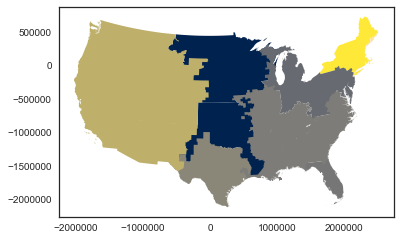

In [34]:
regions_albers.plot(column=2001, cmap='cividis_r')

In [32]:
def plot_nerc_annual(regions_proj, states_proj, data_col, text_col,
                     cmap='cividis_r', vmin=None, vmax=None, title=None,
                     cbar_title=None, **kwargs):
    
    states_ec = kwargs.get('states_ec', '0.6')
    font_size = kwargs.get('font_size', 9)
    bbox_alpha = kwargs.get('bbox_alpha', 0.7)
    FRCC_x = kwargs.get('FRCC_x', 4.75)
    
    
    fig, ax = plt.subplots(figsize=(8,3.5))
    # set aspect to equal. This is done automatically
    # when using *geopandas* plot on it's own, but not when
    # working with pyplot directly.
    ax.set_aspect('equal')


    regions_proj.plot(ax=ax, column=data_col, cmap=cmap, legend=True,
                      vmin=vmin, vmax=vmax)
    states_proj.plot(ax=ax, color='none', edgecolor=states_ec)
    regions_proj.plot(ax=ax, color='none', edgecolor='0.0',
                     linewidth=1)
#     plt.text(x=1.1, y=1.01, s=cbar_title, transform=ax.transAxes,
#              ha='center', va='bottom', fontdict={'size':font_size})
    plt.title(title)

    for point, nerc in zip(regions_proj.centroid, regions_proj['nerc'].values):
        text = regions_proj.loc[regions_proj['nerc']==nerc, text_col].values[0]
#         text = '{}'.format(nerc, reduce)
        x = point.x
        y = point.y
        if nerc == 'FRCC':
            x = x + conv_lon(4.75)#-79
            y = y - conv_lat(1)#28
            rot = -67
            plt.text(x, y, text, ha='center', va='center',
                     fontdict={'size':font_size})

        elif nerc == 'NPCC':
            x = x - conv_lon(1.5)
            y = y + conv_lat(2.1)
            plt.text(x, y, text, ha='center', 
                     fontdict={'size':font_size})

        elif nerc == 'SERC':
            x = x + conv_lon(2)
            y = y - conv_lat(2)
            plt.text(x, y, text, ha='center', va='center',
                     bbox=dict(facecolor='white',
                                alpha=bbox_alpha,
                                boxstyle="square"),
                     fontdict={'size':font_size})
        elif nerc == 'SPP':
    #         x = x + 2
            y = y + conv_lat(1.75)
            plt.text(x, y, text, ha='center', va='center',
                     bbox=dict(facecolor='white',
                                alpha=bbox_alpha,
                                boxstyle="square"),
                     fontdict={'size':font_size})

        else:
            plt.text(x, y, text, ha='center', va='center',
                     bbox=dict(facecolor='white',
                                alpha=bbox_alpha,
                                boxstyle="square"),
                     fontdict={'size':font_size})

    sns.despine(left=True, bottom=True)
    ax.set_yticklabels(labels=[])
    ax.set_xticklabels(labels=[])
    
    cax = fig.get_axes()[-1]
    cax.set_title(cbar_title, fontdict={'size':font_size})

In [28]:
usa_2001 = 629
usa_2017 = 438

regions_albers['2001 diff'] = regions_albers[2001] - usa_2001
regions_albers['2017 diff'] = regions_albers[2017] - usa_2017

In [29]:
regions_albers

,nerc,geometry,2017,2001,reduction,reduction value,2001 diff,2017 diff
0,FRCC,(POLYGON ((1838784.725943641 -2077410.93872188...,410.133060,648.223415,37%,0.367297,19.223415,-27.866940
1,MRO,(POLYGON ((966621.3516970964 71917.95260031865...,541.516736,855.109267,37%,0.366728,226.109267,103.516736
2,NPCC,(POLYGON ((2136199.812043104 -152207.518154806...,172.744904,414.395302,58%,0.583140,-214.604698,-265.255096
3,RFC,(POLYGON ((2099662.549041854 -570869.676621696...,461.065520,676.181487,32%,0.318133,47.181487,23.065520
4,SERC,(POLYGON ((1037399.74436554 -1718942.169221448...,426.814179,633.368212,33%,0.326120,4.368212,-11.185821
5,SPP,(POLYGON ((-185118.2869791386 -730872.89831594...,494.664676,853.801162,42%,0.420632,224.801162,56.664676
6,TRE,(POLYGON ((514101.9059409003 -1674420.05891646...,445.396025,609.480997,27%,0.269221,-19.519003,7.396025
7,WECC,(POLYGON ((-1875597.642457785 -926937.58210479...,346.627554,520.628493,33%,0.334213,-108.371507,-91.372446


In [30]:
# https://gist.github.com/springmeyer/871897

def conv_lon(x):
    newx = x * 20037508.34 / 180
    return newx

def conv_lat(y):
    newy = np.log(np.tan((90 + y) * np.pi / 360)) / (np.pi / 180)
    newy *= 20037508.34 / 180
    return newy

### Maps of 2001 and 2017 annual values

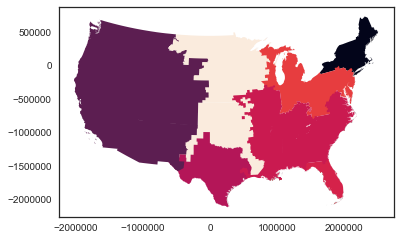

In [36]:
regions_albers.plot(column=2001)

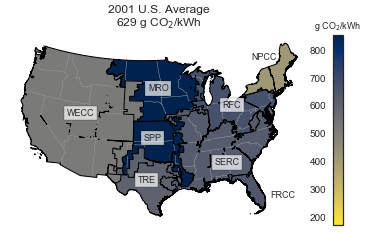

In [35]:
title = '2001 U.S. Average\n{} g CO$_2$/kWh'.format(usa_2001)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col=2001,
                 text_col='nerc', vmin=vmin, vmax=vmax, title=title, cbar_title='g CO$_2$/kWh')

path = join(figure_path, 'NERC map_cividis_2001.png')
# plt.savefig(path, bbox_inches='tight', dpi=350)

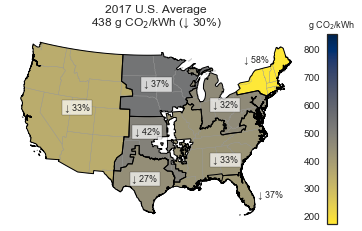

In [442]:
title = '2017 U.S. Average\n{} g CO$_2$/kWh (↓ 30%)'.format(usa_2017)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
regions_albers['arrow reduction'] = '↓ ' + regions_albers['reduction']
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col=2017,
                 text_col='arrow reduction', vmin=vmin, vmax=vmax, title=title, cbar_title='g CO$_2$/kWh')
path = join(figure_path, 'NERC map_cividis_2017_change.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

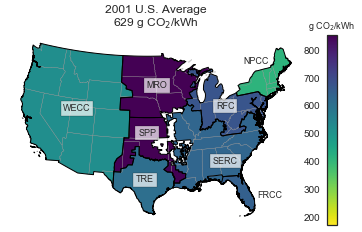

In [450]:
title = '2001 U.S. Average\n{} g CO$_2$/kWh'.format(usa_2001)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers,
                 data_col=2001, cmap='viridis_r',
                 text_col='NERC', vmin=vmin, vmax=vmax, title=title, cbar_title='g CO$_2$/kWh')

path = join(figure_path, 'NERC map_viridis_2001.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

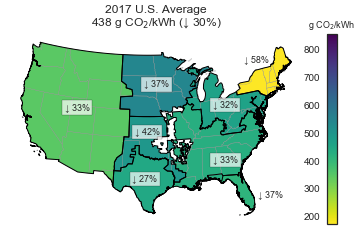

In [451]:
title = '2017 U.S. Average\n{} g CO$_2$/kWh (↓ 30%)'.format(usa_2017)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
regions_albers['arrow reduction'] = '↓ ' + regions_albers['reduction']
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers,
                 data_col=2017,cmap='viridis_r',
                 text_col='arrow reduction', vmin=vmin, vmax=vmax, title=title, cbar_title='g CO$_2$/kWh')
path = join(figure_path, 'NERC map_viridis_2017_change.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

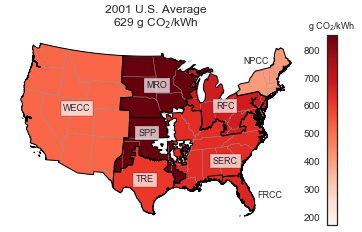

In [443]:
title = '2001 U.S. Average\n{} g CO$_2$/kWh'.format(usa_2001)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col=2001,
                 text_col='NERC', vmin=vmin, vmax=vmax, cmap='Reds',
                 title=title, cbar_title='g CO$_2$/kWh')
path = join(figure_path, 'NERC map_reds_2001.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

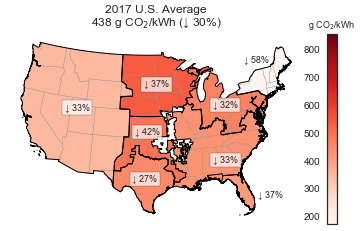

In [444]:
title = '2017 U.S. Average\n{} g CO$_2$/kWh (↓ 30%)'.format(usa_2017)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
regions_albers['arrow reduction'] = '↓ ' + regions_albers['reduction']
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col=2017,
                 text_col='arrow reduction', vmin=vmin, vmax=vmax, cmap='Reds',
                 title=title, cbar_title='g CO$_2$/kWh')
path = join(figure_path, 'NERC map_reds_2017_change.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

### Maps of difference from national average

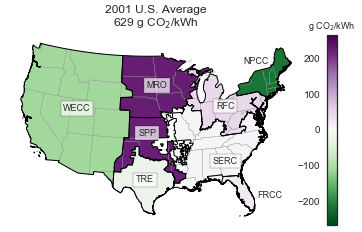

In [448]:
title = '2001 U.S. Average\n{} g CO$_2$/kWh'.format(usa_2001)
vmax = max(abs(regions_albers['2017 diff'].min()), regions_albers['2017 diff'].max())
vmin = -vmax

plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col='2001 diff',
                 text_col='NERC', cmap='PRGn_r', vmin=vmin, vmax=vmax,
                 title=title, cbar_title='g CO$_2$/kWh')
path = join(figure_path, 'NERC map_diverging_2001_2017_bounds.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

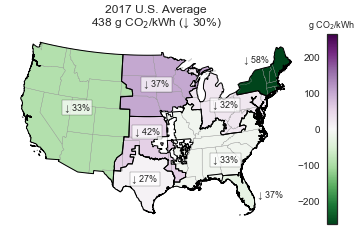

In [446]:
title = '2017 U.S. Average\n{} g CO$_2$/kWh (↓ 30%)'.format(usa_2017)
vmax = max(abs(regions_albers['2017 diff'].min()), regions_albers['2017 diff'].max())
vmin = -vmax

regions_albers['arrow reduction'] = '↓ ' + regions_albers['reduction']
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col='2017 diff',
                 text_col='arrow reduction', cmap='PRGn_r', vmin=vmin, vmax=vmax,
                 title=title, cbar_title='g CO$_2$/kWh')
path = join(figure_path, 'NERC map_diverging_2017.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

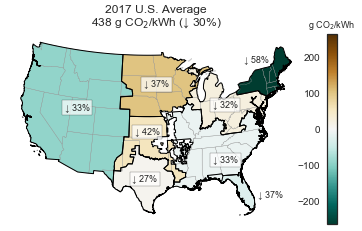

In [447]:
title = '2017 U.S. Average\n{} g CO$_2$/kWh (↓ 30%)'.format(usa_2017)
vmax = max(abs(regions_albers['2017 diff'].min()), regions_albers['2017 diff'].max())
vmin = -vmax

regions_albers['arrow reduction'] = '↓ ' + regions_albers['reduction']
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col='2017 diff',
                 text_col='arrow reduction', cmap='BrBG_r', vmin=vmin, vmax=vmax,
                 title=title, cbar_title='g CO$_2$/kWh')
path = join(figure_path, 'NERC map_diverging_BrBG_2017.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

In [193]:
conv_lat(3.5)

389860.7581999278

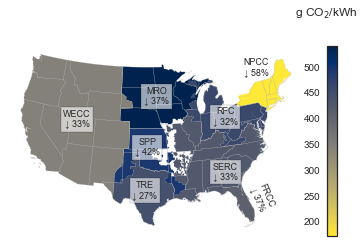

In [309]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='cividis_r', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7', lw=0.2)
plt.text(x=1.07, y=1.15, s='g CO$_2$/kWh', transform=ax.transAxes,
         horizontalalignment='center')

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}\n↓ {}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(3.5)#-79
        y = y + conv_lat(0.4)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 rotation=rot, fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.6,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.25)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.6,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.6,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map.pdf')
# plt.savefig(path, bbox_inches='tight')

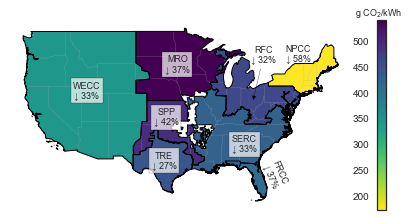

In [274]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='viridis_r', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7', lw=0.1)
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.07, y=1.02, s='g CO$_2$/kWh', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}\n↓ {}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(3.85)#-79
        y = y + conv_lat(0.3)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 rotation=rot, fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'RFC':
        txtx = x + conv_lon(2)
        txty = y + conv_lat(7)
        y -= conv_lat(1.5)
        plt.annotate(xy=(x,y), xytext=(txtx, txty),
                     s=text, ha='center', va='center',
#                      arrowprops=dict(facecolor='black', shrink=0.05)
                     arrowprops={'arrowstyle':'-|>', 'facecolor':'black'},
#                  bbox=dict(facecolor='white',
#                                                     alpha=0.6,
#                                                     boxstyle="square"),
                 size=9
                    )
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_viridis_change_RFC out.pdf')
plt.savefig(path, bbox_inches='tight')

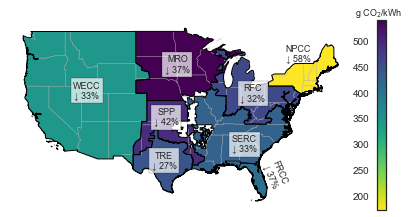

In [240]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='viridis_r', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.07, y=1.02, s='g CO$_2$/kWh', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}\n↓ {}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(3.85)#-79
        y = y + conv_lat(0.3)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 rotation=rot, fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_viridis_change.pdf')
plt.savefig(path, bbox_inches='tight')

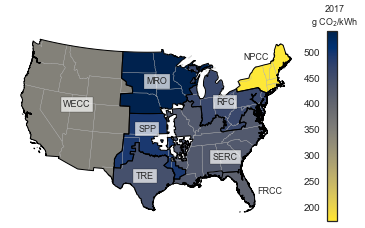

In [363]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='cividis_r', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.1, y=1.01, s='2017\ng CO$_2$/kWh', transform=ax.transAxes,
         ha='center', va='bottom', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(4.75)#-79
        y = y - conv_lat(1)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_cividis.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

In [374]:
regions_merc.loc[:, [2001, 2017]].min().min()

172.74490352250984

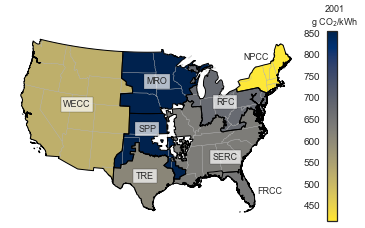

In [370]:
fig, ax = plt.subplots(figsize=(8,3.5))
vmin = regions.merc.loc[:, [2001, 2017]].min().min()
vmax = regions.merc.loc[:, [2001, 2017]].max().max()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2001, cmap='cividis_r', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.1, y=1.01, s='2001\ng CO$_2$/kWh', transform=ax.transAxes,
         ha='center', va='bottom', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(4.75)#-79
        y = y - conv_lat(1)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_cividis_2001.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

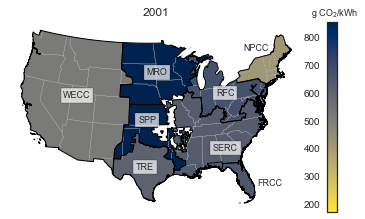

In [379]:
fig, ax = plt.subplots(figsize=(8,3.5))
vmin = regions_merc.loc[:, [2001, 2017]].min().min()
vmax = regions_merc.loc[:, [2001, 2017]].max().max()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2001, cmap='cividis_r', legend=True,
                  vmin=vmin, vmax=vmax) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.1, y=1.01, s='g CO$_2$/kWh', transform=ax.transAxes,
         ha='center', va='bottom', fontdict={'size':9})
plt.title('2001')

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(4.75)#-79
        y = y - conv_lat(1)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_cividis_2001.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

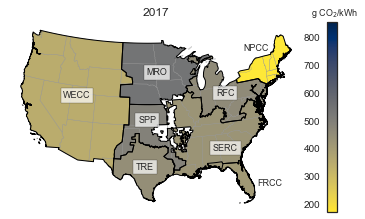

In [381]:
fig, ax = plt.subplots(figsize=(8,3.5))
vmin = regions_merc.loc[:, [2001, 2017]].min().min()
vmax = regions_merc.loc[:, [2001, 2017]].max().max()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='cividis_r', legend=True,
                  vmin=vmin, vmax=vmax) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.6')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.1, y=1.01, s='g CO$_2$/kWh', transform=ax.transAxes,
         ha='center', va='bottom', fontdict={'size':9})
plt.title('2017')

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(4.75)#-79
        y = y - conv_lat(1)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_cividis_2017.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

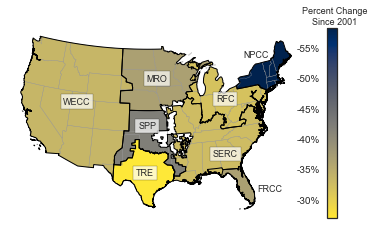

In [362]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column='reduction value', cmap='cividis_r', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.6')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.1, y=1.01, s='Percent Change\nSince 2001', transform=ax.transAxes,
         ha='center', va='bottom', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(4.75)#-79
        y = y - conv_lat(1)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])

cax = fig.get_axes()[-1]
cax_label_numbers = range(30, 60, 5)
cax.set_yticklabels(['-{}%'.format(x) for x in cax_label_numbers])


path = join(figure_path, 'NERC map_cividis_percent_change.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

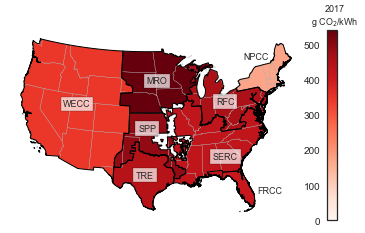

In [382]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='Reds', legend=True, vmin=0) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.1, y=1.01, s='2017\ng CO$_2$/kWh', transform=ax.transAxes,
         ha='center', va='bottom', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(4.75)#-79
        y = y - conv_lat(1)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_reds.png')
# plt.savefig(path, bbox_inches='tight', dpi=350)

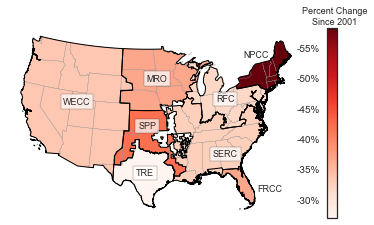

In [365]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column='reduction value', cmap='Reds', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.6')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.1, y=1.01, s='Percent Change\nSince 2001', transform=ax.transAxes,
         ha='center', va='bottom', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(4.75)#-79
        y = y - conv_lat(1)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])

cax = fig.get_axes()[-1]
cax_label_numbers = range(30, 60, 5)
cax.set_yticklabels(['-{}%'.format(x) for x in cax_label_numbers])


path = join(figure_path, 'NERC map_reds_percent_change.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

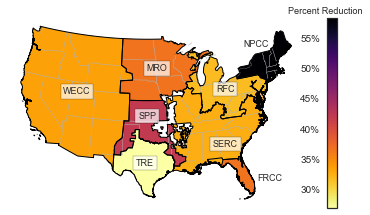

In [351]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column='reduction value', cmap='inferno_r', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.07, y=1.02, s='Percent Reduction', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(4.75)#-79
        y = y - conv_lat(1)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])

cax = fig.get_axes()[-1]
cax_label_numbers = range(30, 60, 5)
cax.set_yticklabels(['{}%'.format(x) for x in cax_label_numbers])


path = join(figure_path, 'NERC map_inferno_percent_change.pdf')
plt.savefig(path, bbox_inches='tight')

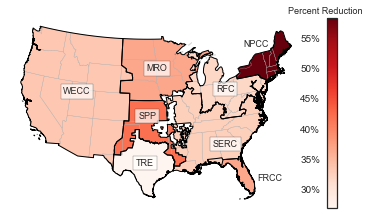

In [350]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column='reduction value', cmap='Reds', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.07, y=1.02, s='Percent Reduction', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(4.75)#-79
        y = y - conv_lat(1)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])

cax = fig.get_axes()[-1]
cax_label_numbers = range(30, 60, 5)
cax.set_yticklabels(['{}%'.format(x) for x in cax_label_numbers])


path = join(figure_path, 'NERC map_reds_percent_change.pdf')
plt.savefig(path, bbox_inches='tight')

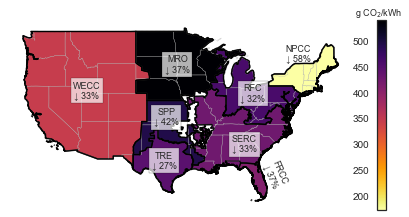

In [275]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='inferno_r', legend=True, edgecolor='0.1',
                 linewidth=1.5) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.07, y=1.02, s='g CO$_2$/kWh', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}\n↓ {}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(3.85)#-79
        y = y + conv_lat(0.3)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 rotation=rot, fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_inferno_change.pdf')
plt.savefig(path, bbox_inches='tight')

In [277]:
regions_merc

,NERC,NERC_Label,geometry,2017,reduction
1,FRCC,Florida Reliability Coordinating Council (FRCC),(POLYGON ((-9123196.218054753 2816863.69312617...,410.133060,37%
2,MRO,Midwest Reliability Organization (MRO),POLYGON ((-10583309.41571185 6336939.110909222...,541.516736,37%
3,NPCC,Northeast Power Coordinating Council (NPCC),(POLYGON ((-8217754.407057152 4954179.43304838...,172.744904,58%
4,RFC,ReliabilityFirst Corporation (RFC),(POLYGON ((-10118229.11608242 3381601.80027649...,461.065520,32%
5,SERC,SERC Reliability Corporation (SERC),(POLYGON ((-10209358.34147486 3892073.99650534...,426.814179,33%
6,SPP,Southwest Power Pool (SPP),(POLYGON ((-10434321.79737117 3556846.33753678...,494.664676,42%
7,TRE,Texas Reliability Entity (TRE),POLYGON ((-11132045.14426304 4167890.966573395...,445.396025,27%
8,WECC,Western Electricity Coordinating Council (WECC),(POLYGON ((-13048334.56595229 3865790.88659270...,346.627554,33%


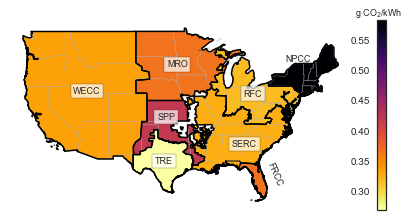

In [284]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column='reduction value', cmap='inferno_r', legend=True, edgecolor='0.1',
                 linewidth=1.5) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.07, y=1.02, s='g CO$_2$/kWh', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):

    text = '{}'.format(nerc)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(3.85)#-79
        y = y + conv_lat(0.3)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 rotation=rot, fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_inferno_change.pdf')
# plt.savefig(path, bbox_inches='tight')

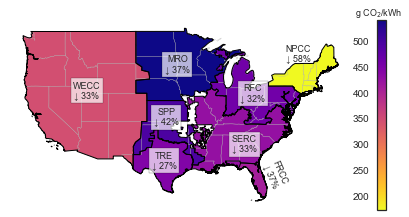

In [243]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='plasma_r', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)

plt.text(x=1.07, y=1.02, s='g CO$_2$/kWh', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}\n↓ {}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(3.85)#-79
        y = y + conv_lat(0.3)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 rotation=rot, fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_plasma_change.pdf')
plt.savefig(path, bbox_inches='tight')

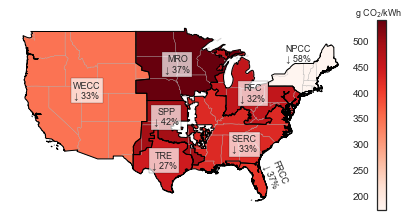

In [244]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='Reds', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.07, y=1.02, s='g CO$_2$/kWh', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    reduce = regions.loc[regions['NERC']==nerc, 'reduction'].values[0]
    text = '{}\n↓ {}'.format(nerc, reduce)
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + conv_lon(3.85)#-79
        y = y + conv_lat(0.3)#28
        rot = -67
        plt.text(x, y, text, ha='center', va='center',
                 rotation=rot, fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - conv_lon(1.5)
        y = y + conv_lat(2.1)
        plt.text(x, y, text, ha='center',
                 fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + conv_lon(2)
        y = y - conv_lat(2)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + conv_lat(1.75)
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, text, ha='center', va='center',
                 bbox=dict(facecolor='white',
                                                    alpha=0.7,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_reds_change.pdf')
plt.savefig(path, bbox_inches='tight')

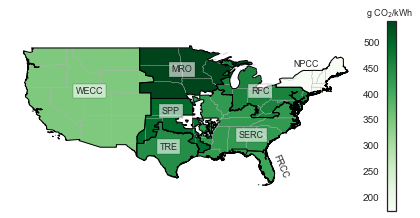

In [142]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='Greens', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
regions_merc.plot(ax=ax, color='none', edgecolor='0.0',
                 linewidth=1)
plt.text(x=1.07, y=1.15, s='g CO$_2$/kWh', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + 3.5#-79
        y = y + 0.4#28
        rot = -67
        plt.text(x, y, nerc, ha='center',  rotation=rot, fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - 1.5
        y = y + 2
        plt.text(x, y, nerc, ha='center', fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + 2
        y = y - 2
        plt.text(x, y, nerc, ha='center', bbox=dict(facecolor='white',
                                                    alpha=0.6,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + 1.25
        plt.text(x, y, nerc, ha='center', bbox=dict(facecolor='white',
                                                    alpha=0.6,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, nerc, ha='center', bbox=dict(facecolor='white',
                                                    alpha=0.6,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_greens.pdf')
plt.savefig(path, bbox_inches='tight')

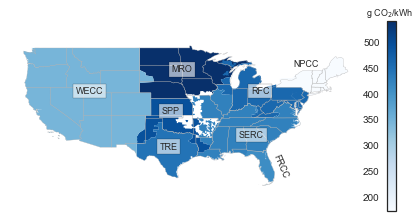

In [118]:
fig, ax = plt.subplots(figsize=(8,3.5))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')


regions_merc.plot(ax=ax, column=2017, cmap='Blues', legend=True) 
states_merc.to_crs(crs_proj4).plot(ax=ax, color='none', edgecolor='0.7')
plt.text(x=1.07, y=1.15, s='g CO$_2$/kWh', transform=ax.transAxes,
         horizontalalignment='center', fontdict={'size':9})

for point, nerc in zip(regions_merc.centroid, regions_merc['NERC'].values):
    x = point.x
    y = point.y
    if nerc == 'FRCC':
        x = x + 3.5#-79
        y = y + 0.4#28
        rot = -67
        plt.text(x, y, nerc, ha='center',  rotation=rot, fontdict={'size':9})
        
    elif nerc == 'NPCC':
        x = x - 1.5
        y = y + 2
        plt.text(x, y, nerc, ha='center', fontdict={'size':9})
        
    elif nerc == 'SERC':
        x = x + 2
        y = y - 2
        plt.text(x, y, nerc, ha='center', bbox=dict(facecolor='white',
                                                    alpha=0.6,
                                                    boxstyle="square"),
                 fontdict={'size':9})
    elif nerc == 'SPP':
#         x = x + 2
        y = y + 1.25
        plt.text(x, y, nerc, ha='center', bbox=dict(facecolor='white',
                                                    alpha=0.6,
                                                    boxstyle="square"),
                 fontdict={'size':9})
        
    else:
        plt.text(x, y, nerc, ha='center', bbox=dict(facecolor='white',
                                                    alpha=0.6,
                                                    boxstyle="square"),
                 fontdict={'size':9})

sns.despine(left=True, bottom=True)
ax.set_yticklabels(labels=[])
ax.set_xticklabels(labels=[])
path = join(figure_path, 'NERC map_blues.pdf')
plt.savefig(path, bbox_inches='tight')

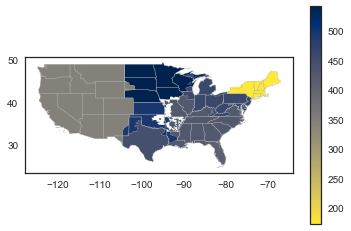

In [77]:
base = regions.iloc[1:].plot(column=2017, cmap='cividis_r', legend=True)
states.plot(ax=base, color='none', edgecolor='0.7')
# ax = plt.gca()
# plt.text(x=1.07, y=1.25, s='g CO$_2$/kWh', transform=ax.transAxes, horizontalalignment='center')
# sns.despine(left=True, bottom=True)
# ax.set_yticklabels(labels=[])
# ax.set_xticklabels(labels=[])

## Read file with facility location, generation, and fuel data

In [12]:
path = os.path.join(data_path, 'Facility gen fuels and CO2 2017-08-31.zip')
facility_df = pd.read_csv(path)

### Drop plants without lat/lon data
From 2001-mid 2017, 9 facilities (out of 8,435) don't have valid lat/lon data. All of them are from 2010 or earlier. Drop these rows or the spatial join fails. The amount of generation from these plants is tiny - well under 0.05% in all years.

In [7]:
print(len(facility_df['plant id'].unique()), 'total plants')
print(len(facility_df.loc[facility_df['lat'].isnull(), 'plant id'].unique()),
      'plants without lat/lon')

8435 total plants
9 plants without lat/lon


In [8]:
years = facility_df.loc[facility_df['lat'].isnull(), 'year'].unique()
for year in years:
    total_gen = facility_df.loc[facility_df['year'] == year, 'generation (MWh)'].sum()
    
    # Plant ids with no 'lat' in year
    no_loc_plants = facility_df.loc[(facility_df['lat'].isnull()) & 
                                    (facility_df['year'] == year), 'plant id'].unique()
    
    no_loc_gen = facility_df.loc[(facility_df['year'] == year) &
                                 (facility_df['plant id'].isin(no_loc_plants)),
                                  'generation (MWh)'].sum()
    
    percent_dropped = no_loc_gen / total_gen * 100
    
    print('In {}, {:.3f}% of generation is from plants without lat/lon'.format(year, percent_dropped))

In 2006, 0.000% of generation is from plants without lat/lon
In 2005, 0.001% of generation is from plants without lat/lon
In 2004, 0.001% of generation is from plants without lat/lon
In 2002, 0.024% of generation is from plants without lat/lon
In 2001, 0.031% of generation is from plants without lat/lon
In 2010, 0.000% of generation is from plants without lat/lon
In 2009, 0.000% of generation is from plants without lat/lon
In 2007, 0.000% of generation is from plants without lat/lon
In 2003, 0.011% of generation is from plants without lat/lon


In [9]:
facility_df.dropna(inplace=True, subset=['lat', 'lon'])

In [10]:
facility_df.columns

Index(['f', 'fuel', 'month', 'plant id', 'total fuel (mmbtu)', 'year',
       'generation (MWh)', 'elec fuel (mmbtu)', 'geography', 'last_updated',
       'lat', 'lon', 'prime mover', 'datetime', 'quarter',
       'all fuel fossil CO2 (kg)', 'elec fuel fossil CO2 (kg)',
       'all fuel total CO2 (kg)', 'elec fuel total CO2 (kg)'],
      dtype='object')

Because I have monthly data for every facility from 2001-2017, there are lots of duplicate rows. No need to do a spatial join on every row. Just keep one instance of each facility in each year.

In [11]:
cols = ['lat', 'lon', 'plant id', 'year']
small_facility = facility_df.loc[:, cols].drop_duplicates()

Use `Point` from Shapely to create the `geometry` list of facility locations. `crs` is the coordinate reference system that translates lat/lon into a specific map projection.

In [12]:
geometry = [Point(xy) for xy in zip(small_facility.lon, small_facility.lat)]
# small_facility = small_facility.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(small_facility, crs=crs, geometry=geometry)

In [13]:
geo_df.head()

,lat,lon,plant id,year,geometry
0,44.4936,-88.0303,10360,2017,POINT (-88.0303 44.4936)
6,44.4936,-88.0303,10360,2016,POINT (-88.0303 44.4936)
18,44.4936,-88.0303,10360,2015,POINT (-88.0303 44.4936)
30,44.4936,-88.0303,10360,2014,POINT (-88.0303 44.4936)
38,44.4936,-88.0303,10360,2008,POINT (-88.0303 44.4936)


In [14]:
len(geo_df)

88918

## Spatial join of NERC dataframe with polygons and facility dataframe with points
Joining the 9 regions (NERC) with 100,810 records takes much longer with facilities as the left dataframe in the join (2 min vs 12 seconds). Not quite sure why this is. The faster method leaves me with polygons rather than points tho. There might be a better way to rectify this, but I just create a new geodataframe with the geometry set as the lat/lon points.

**EDIT**
Although the GeoPandas documentation says that the `op` parameter doesn't matter for point-in-polygon operations, using 'within' made the operation much faster (12 seconds). The first method below is probably preferable since it keeps the point geometry.

**Method 1** (slow unless you use `op='within'`)

In [15]:
facility_nerc = gpd.sjoin(geo_df, regions, how='inner', op='within')

In [16]:
facility_nerc.head()

,lat,lon,plant id,year,geometry,index_right,NERC,NERC_Label
0,44.4936,-88.0303,10360,2017,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)
6,44.4936,-88.0303,10360,2016,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)
18,44.4936,-88.0303,10360,2015,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)
30,44.4936,-88.0303,10360,2014,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)
38,44.4936,-88.0303,10360,2008,POINT (-88.0303 44.4936),2,MRO,Midwest Reliability Organization (MRO)


**Method 2** (faster when using the default operation)

In [10]:
facility_nerc = gpd.sjoin(df, geo_df, how="inner")

In [11]:
facility_nerc.head()

,NERC,NERC_Label,geometry,index_right,lat,lon,plant id,year
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200931,40.389167,-91.394167,57953,2014
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200919,40.389167,-91.394167,57953,2015
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200907,40.389167,-91.394167,57953,2016
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1200904,40.389167,-91.394167,57953,2017
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,1201030,40.389167,-91.394167,57953,2011


Make the new geometry of facility locations

In [12]:
geometry = [Point(xy) for xy in zip(facility_nerc.lon, facility_nerc.lat)]

Create new dataframe with the data I want to keep and the new geometry

In [13]:
crs = {'init': 'epsg:4326'}
keep_cols = ['NERC_Label', 'plant id', 'year']
facility_nerc = GeoDataFrame(facility_nerc[keep_cols], crs=crs, geometry=geometry)

In [14]:
facility_nerc.head()

,NERC_Label,plant id,year,geometry
0,Indeterminate - various NERC membership,57953,2014,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2015,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2016,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2017,POINT (-91.39416700000001 40.389167)
0,Indeterminate - various NERC membership,57953,2011,POINT (-91.39416700000001 40.389167)


## Changing the crs to see what happens
Just making sure that it does something

In [31]:
df_test = df.to_crs({'init': 'epsg:3395'})

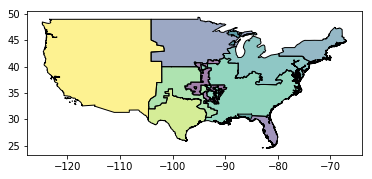

In [32]:
df.plot()

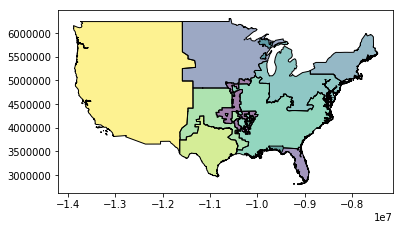

In [33]:
df_test.plot()

## NEW - read file with only plant id, state, and lat/lon
[Link to data file](https://github.com/gschivley/Index-variability/raw/master/Data%20storage/Facility%20labels/Facility%20locations.csv)

If you need to load the shapefile, [download it here](https://github.com/gschivley/Index-variability/raw/master/Data%20storage/NERC_Regions_EIA).

In [ ]:
# If loading the shapefile
shape_path = ''
regions = gpd.read_file(shape_path)

In [3]:
path = join(data_path, 'Facility labels', 'Facility locations.csv')
location = pd.read_csv(path)

In [20]:
len(location)

8217

The `nerc` column is labels from a spatial join using this same shapefile and lat/lon data in QGIS.

In [21]:
location.head()

,plant id,state,lat,lon,nerc
0,2,AL,33.458665,-87.356823,SERC
1,3,AL,31.006900,-88.010300,SERC
2,4,AL,32.583889,-86.283056,SERC
3,7,AL,34.012800,-85.970800,SERC
4,8,AL,33.644344,-87.196486,SERC


In [22]:
location.loc[location['lat'].isnull()]

,plant id,state,lat,lon,nerc


In [4]:
geometry = [Point(xy) for xy in zip(location.lon, location.lat)]
# small_facility = small_facility.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(location, crs=crs, geometry=geometry)

In [5]:
geo_df.head()

,plant id,state,lat,lon,nerc,geometry
0,2,AL,33.458665,-87.356823,SERC,POINT (-87.35682299999999 33.458665)
1,3,AL,31.006900,-88.010300,SERC,POINT (-88.0103 31.0069)
2,4,AL,32.583889,-86.283056,SERC,POINT (-86.283056 32.583889)
3,7,AL,34.012800,-85.970800,SERC,POINT (-85.9708 34.0128)
4,8,AL,33.644344,-87.196486,SERC,POINT (-87.19648599999999 33.644344)


**Every plant id is unique**

In [24]:
len(geo_df)

8099

In [25]:
len(geo_df['plant id'].unique())

8099

### Method 1 - use defaults

In [26]:
df1 = gpd.sjoin(regions, geo_df)

In [27]:
df1.head()

,NERC,NERC_Label,geometry,index_right,plant id,state,lat,lon,nerc
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,4381,54930,IA,40.584150,-91.424530,-
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,639,1127,IA,40.703100,-92.425300,-
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,629,1104,IA,40.741200,-91.116667,-
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,630,1105,IA,40.747800,-92.873056,-
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,2562,7706,IA,40.816736,-91.146667,-


We can already see that there are more rows in this dataframe than there were power plants.

In [28]:
len(df1)

8135

### Method 2 - use 'within'

In [6]:
df2 = gpd.sjoin(geo_df, regions, op='within')

In [31]:
df2.head()

,plant id,state,lat,lon,nerc,geometry,index_right,NERC,NERC_Label
0,2,AL,33.458665,-87.356823,SERC,POINT (-87.35682299999999 33.458665),5,SERC,SERC Reliability Corporation (SERC)
1,3,AL,31.006900,-88.010300,SERC,POINT (-88.0103 31.0069),5,SERC,SERC Reliability Corporation (SERC)
2,4,AL,32.583889,-86.283056,SERC,POINT (-86.283056 32.583889),5,SERC,SERC Reliability Corporation (SERC)
3,7,AL,34.012800,-85.970800,SERC,POINT (-85.9708 34.0128),5,SERC,SERC Reliability Corporation (SERC)
4,8,AL,33.644344,-87.196486,SERC,POINT (-87.19648599999999 33.644344),5,SERC,SERC Reliability Corporation (SERC)


Same size dataframe as from Method 1. Yet again, there appear to be extra results.

In [26]:
len(df2)

8135

### Method 3 - use 'contains'

In [39]:
df3 = gpd.sjoin(regions, geo_df, op='contains')

In [40]:
df3.head()

,NERC,NERC_Label,geometry,index_right,plant id,state,lat,lon
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,4387,55340,AR,35.861900,-90.025300
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,6136,172,AR,35.689300,-89.994000
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,152,8055,AR,35.311000,-93.235100
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,6217,187,AR,34.211913,-93.110963
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...,2928,59947,AR,33.631538,-92.703611


Still too many results

In [41]:
len(df3)

8135

### What facilities are missing?

In [32]:
regions

,NERC,NERC_Label,geometry
index_right,,,
0,-,Indeterminate - various NERC membership,(POLYGON ((-91.71222639199999 32.9756623780000...
1,FRCC,Florida Reliability Coordinating Council (FRCC),(POLYGON ((-81.95506602699999 24.5196900770000...
2,MRO,Midwest Reliability Organization (MRO),POLYGON ((-95.07148604699995 49.36451082200006...
3,NPCC,Northeast Power Coordinating Council (NPCC),(POLYGON ((-73.82134384999995 40.6045004290000...
4,RFC,ReliabilityFirst Corporation (RFC),(POLYGON ((-90.89359863199996 29.0467829150000...
5,SERC,SERC Reliability Corporation (SERC),(POLYGON ((-91.71222639199999 32.9756623780000...
6,SPP,Southwest Power Pool (SPP),(POLYGON ((-93.73310749999996 30.4137588960000...
7,TRE,Texas Reliability Entity (TRE),POLYGON ((-100.0008629659999 35.02950123100004...
8,WECC,Western Electricity Coordinating Council (WECC),"(POLYGON ((-117.215183729 32.77737140300007, -..."


In [23]:
frcc = regions.loc[1, 'geometry']
serc = regions.loc[5, 'geometry']

I figured out that plant id 641 is one that shows up in both FRCC and SERC

In [27]:
plant_641 = geo_df.loc[geo_df['plant id'] == 641, 'geometry'].values[0]

In [28]:
frcc.contains(plant_641)

True

In [29]:
serc.contains(plant_641)

True

So 641 definitely is in both NERC regions. And apparently the regions overlap? But they aren't supposed to. And I didn't have any plants show up in multiple regions when doing the spatial join in QGIS.

In [37]:
frcc.intersects(serc)

True

There are 36 plants with duplicate NERC regions.

In [38]:
len(df2.loc[df2['plant id'].duplicated()].sort_values('plant id'))

36

In [10]:
pd.set_option('display.max_rows', 200)

In [11]:
df2.loc[df2['plant id'].duplicated(keep=False)].sort_values('plant id')

,plant id,state,lat,lon,nerc,geometry,index_right,NERC,NERC_Label
406,641,FL,30.566100,-87.224400,FRCC,POINT (-87.2244 30.5661),5,SERC,SERC Reliability Corporation (SERC)
406,641,FL,30.566100,-87.224400,FRCC,POINT (-87.2244 30.5661),1,FRCC,Florida Reliability Coordinating Council (FRCC)
407,642,FL,30.669200,-84.886900,FRCC,POINT (-84.8869 30.6692),5,SERC,SERC Reliability Corporation (SERC)
407,642,FL,30.669200,-84.886900,FRCC,POINT (-84.8869 30.6692),1,FRCC,Florida Reliability Coordinating Council (FRCC)
408,643,FL,30.268600,-85.700300,FRCC,POINT (-85.7003 30.2686),5,SERC,SERC Reliability Corporation (SERC)
408,643,FL,30.268600,-85.700300,FRCC,POINT (-85.7003 30.2686),1,FRCC,Florida Reliability Coordinating Council (FRCC)
432,690,FL,30.708571,-84.863869,FRCC,POINT (-84.86386899999999 30.708571),5,SERC,SERC Reliability Corporation (SERC)
432,690,FL,30.708571,-84.863869,FRCC,POINT (-84.86386899999999 30.708571),1,FRCC,Florida Reliability Coordinating Council (FRCC)
963,1773,MI,46.726100,-88.662500,MRO,POINT (-88.66249999999999 46.7261),4,RFC,ReliabilityFirst Corporation (RFC)
963,1773,MI,46.726100,-88.662500,MRO,POINT (-88.66249999999999 46.7261),2,MRO,Midwest Reliability Organization (MRO)


In [17]:
facility_df.head()

,f,fuel,month,plant id,total fuel (mmbtu),year,generation (MWh),elec fuel (mmbtu),geography,last_updated,lat,lon,prime mover,datetime,quarter,all fuel fossil CO2 (kg),elec fuel fossil CO2 (kg),all fuel total CO2 (kg),elec fuel total CO2 (kg)
0,M,SUB,6,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-06-01,2,0.0,0.0,0.0,0.0
1,M,SUB,5,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-05-01,2,0.0,0.0,0.0,0.0
2,M,SUB,4,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-04-01,2,0.0,0.0,0.0,0.0
3,M,SUB,3,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-03-01,1,0.0,0.0,0.0,0.0
4,M,SUB,2,10360,0.0,2017,0.0,0.0,USA-WI,2017-08-24T11:46:12-04:00,44.4936,-88.0303,ALL,2017-02-01,1,0.0,0.0,0.0,0.0


In [49]:
plants = facility_df.loc[:, ['plant id', 'year', 'lat', 'lon']]
plants.drop_duplicates(inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1165f8ef0>]], dtype=object)

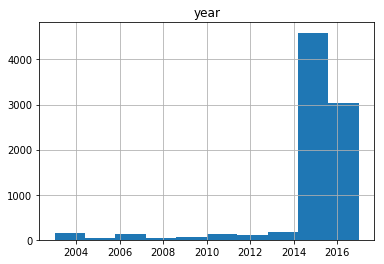

In [24]:
plants.groupby(['plant id']).max().hist()

In [116]:
path = join(data_path, 'EIA downloads', 'EIA-860 2015', '2___Plant_Y2015.xlsx')
nercs2015 = pd.read_excel(path, skiprows=0, parse_cols='C,L')
nercs2015.columns = ['plant id', 'nerc']

path = join(data_path, 'EIA downloads', 'eia8602012', 'PlantY2012.xlsx')
nercs2012 = pd.read_excel(path, skiprows=0, parse_cols='B,J')
nercs2012.columns = ['plant id', 'nerc']

In [117]:
nercs2012.head()

,plant id,nerc
0,10867,SERC
1,50903,RFC
2,10671,SPP
3,2527,NPCC
4,3305,SERC


In [118]:
nercs = pd.concat([nercs2012, nercs2015]).drop_duplicates()

In [119]:
len(nercs), len(nercs2012), len(nercs2015)

(9178, 7289, 8928)

In [120]:
df = pd.merge(plants, nercs, on=['plant id'], how='left')

In [121]:
plants.tail()

,plant id,year,lat,lon
1544548,1275,2006,38.947222,-99.528611
1544560,1275,2005,38.947222,-99.528611
1544572,1275,2004,38.947222,-99.528611
1544584,1275,2003,38.947222,-99.528611
1544596,1275,2002,38.947222,-99.528611


In [122]:
nercs.tail()

,plant id,nerc
8923,60510,SERC
8924,60511,WECC
8925,60514,SERC
8926,60550,SERC
8927,60571,WECC


In [123]:
nercs.nerc.unique()

array(['SERC', 'RFC', 'SPP', 'NPCC', 'WECC', 'MRO', 'TRE', 'HICC', 'ASCC',
       'FRCC', nan], dtype=object)

In [67]:
df.tail()

,plant id,year,lat,lon,nerc
89242,1275,2006,38.947222,-99.528611,SPP
89243,1275,2005,38.947222,-99.528611,SPP
89244,1275,2004,38.947222,-99.528611,SPP
89245,1275,2003,38.947222,-99.528611,SPP
89246,1275,2002,38.947222,-99.528611,SPP


In [63]:
len(df.loc[df.isnull().any(axis=1), 'plant id'].unique())

88

In [148]:
from sklearn import neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

In [124]:
nercs = ['SERC', 'RFC', 'SPP', 'NPCC', 'WECC', 'MRO', 'TRE', 'FRCC']

In [125]:
df_slim = df.loc[df.nerc.isin(nercs), ['plant id', 'lat', 'lon', 'nerc']].dropna(subset=['lon']).drop_duplicates()

In [126]:
unknown = df_slim.loc[df_slim.nerc.isnull()]

In [69]:
n_neighbors = 10

In [155]:
X = df_slim.loc[df_slim.notnull().all(axis=1), ['lat', 'lon']]
y = df_slim.loc[df_slim.notnull().all(axis=1), 'nerc']

X_scale = StandardScaler().fit_transform(X)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [128]:
y.unique()

array(['MRO', 'WECC', 'NPCC', 'SERC', 'SPP', 'RFC', 'FRCC', 'TRE'], dtype=object)

In [165]:
knn = neighbors.KNeighborsClassifier()

In [ ]:
params = {'weights': ['uniform', 'distance'],
          'n_neighbors': [10, 15, 20, 30],
          'leaf_size': [3, 5, 10, 30],
          'p': [1, 2]}

clf = GridSearchCV(knn, params, n_jobs=-1)

In [160]:
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': [10, 15, 20, 30], 'leaf_size': [3, 5, 10, 30], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [161]:
clf.best_estimator_, clf.best_params_, clf.best_score_

(KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=15, p=1,
            weights='distance'),
 {'leaf_size': 3, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'},
 0.96590695046148045)

No difference in score when X is preprocessed with `StandardScaler`

In [163]:
clf.score(X_scale, y)

0.98498422712933753

In [102]:
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [103]:
clf.score(X_test, y_test)

0.95693087224031848

In [104]:
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')

In [105]:
clf.score(X_test, y_test)

0.95946435034382915

AttributeError: 'str' object has no attribute 'view'

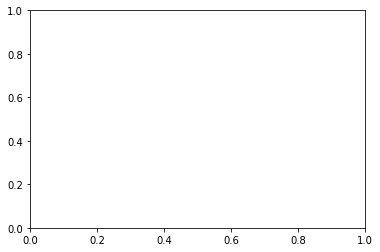

In [95]:
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))